## Imports

In [1]:
import pandas as pd
from pathlib import Path
import pickle
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, classification_report
import pprint
import json
import seaborn as sns; sns.set(style="ticks", color_codes=True)

## Envs

In [2]:
input_filepath = '../data/processed/'
output_filepath = '../models/'
pred_filepath = '../data/raw/'

# cols
BINARY_COLS = Path.cwd().joinpath(input_filepath).joinpath('binary-cols.pickle')
CATEGORICAL_COLS = Path.cwd().joinpath(input_filepath).joinpath('categorical-cols.pickle')
CONTINUOUS_COLS = Path.cwd().joinpath(input_filepath).joinpath('continuous-cols.pickle')
TARGET_COL = Path.cwd().joinpath(input_filepath).joinpath('target-col.pickle')

BINARY_COLS_OUT = Path.cwd().joinpath(output_filepath).joinpath('binary-cols.pickle')
CATEGORICAL_COLS_OUT = Path.cwd().joinpath(output_filepath).joinpath('categorical-cols.pickle')
CONTINUOUS_COLS_OUT = Path.cwd().joinpath(output_filepath).joinpath('continuous-cols.pickle')
TARGET_COL_OUT = Path.cwd().joinpath(output_filepath).joinpath('target-col.pickle')

COL_ORDER = Path.cwd().joinpath(output_filepath).joinpath('col-order.pickle')

# data
TRAIN_CSV = Path.cwd().joinpath(input_filepath).joinpath('train.csv')
VAL_CSV = Path.cwd().joinpath(input_filepath).joinpath('val.csv')
TEST_CSV = Path.cwd().joinpath(input_filepath).joinpath('test.csv')
PRED_CSV = Path.cwd().joinpath(pred_filepath).joinpath('unlabeled.csv')

# metadata
BINARY_ENCODERS = Path.cwd().joinpath(input_filepath).joinpath('binary-encoders.pickle')
CATEGORICAL_ENCODERS = Path.cwd().joinpath(input_filepath).joinpath('categorical-encoders.pickle')
TARGET_ENCODERS = Path.cwd().joinpath(input_filepath).joinpath('target-encoders.pickle')
CONTINUOUS_SCALERS = Path.cwd().joinpath(input_filepath).joinpath('continuous-scalers.pickle')

BINARY_ENCODERS_OUT = Path.cwd().joinpath(output_filepath).joinpath('binary-encoders.pickle')
CATEGORICAL_ENCODERS_OUT = Path.cwd().joinpath(output_filepath).joinpath('categorical-encoders.pickle')
TARGET_ENCODERS_OUT = Path.cwd().joinpath(output_filepath).joinpath('target-encoders.pickle')
CONTINUOUS_SCALERS_OUT = Path.cwd().joinpath(output_filepath).joinpath('continuous-scalers.pickle')

# model
MODEL = Path.cwd().joinpath(output_filepath).joinpath('catboost_model.dump')

# model results
VAL_RESULTS = Path.cwd().joinpath(output_filepath).joinpath('val-results.txt')
TEST_RESULTS = Path.cwd().joinpath(output_filepath).joinpath('test-results.txt')

## Load Data

In [3]:
def read_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    return None

In [4]:
# Cols
binary_cols = read_obj(BINARY_COLS)
categorical_cols = read_obj(CATEGORICAL_COLS)
continuous_cols = read_obj(CONTINUOUS_COLS)
target_col = read_obj(TARGET_COL)

col_order = read_obj(COL_ORDER)

# Metadata
ohe_encoders = read_obj(BINARY_ENCODERS)
label_encoders = read_obj(CATEGORICAL_ENCODERS)
scalers = read_obj(TARGET_ENCODERS)
target_encoders = read_obj(CONTINUOUS_SCALERS)

# Data
X_train = pd.read_csv(TRAIN_CSV)
X_val = pd.read_csv(VAL_CSV)
X_test = pd.read_csv(TEST_CSV)
df = pd.read_csv(PRED_CSV)

# Model
model = CatBoostClassifier()
model.load_model(str(MODEL))

In [5]:
X_train = X_train[binary_cols + categorical_cols + continuous_cols + [target_col]]
X_val = X_val[binary_cols + categorical_cols + continuous_cols + [target_col]]
X_test = X_test[binary_cols + categorical_cols + continuous_cols + [target_col]]
df = df[binary_cols + categorical_cols + continuous_cols + [target_col]]

In [6]:
y_train = X_train.pop(target_col)
y_val = X_val.pop(target_col)
y_test = X_test.pop(target_col)

In [7]:
X_train = X_train[col_order]
X_val = X_val[col_order]
X_test = X_test[col_order]
df = df[col_order]

## Concat

In [8]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

## Get Predictions

In [9]:
y_train_preds = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)
y_train_proba_death = y_train_proba[:,1]

In [10]:
y_val_preds = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)
y_val_proba_death = y_val_proba[:,1]

In [11]:
y_test_preds = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)
y_test_proba_death = y_test_proba[:,1]

## Get Failed Inference

In [12]:
bad_train = y_train != y_train_preds
bad_val = y_val != y_val_preds
bad_test = y_test != y_test_preds

In [13]:
good_train = y_train == y_train_preds
good_val = y_val == y_val_preds
good_test = y_test == y_test_preds

In [14]:
train.shape, val.shape, test.shape

((74286, 186), (8255, 186), (9172, 186))

In [38]:
train.loc[train.index == bad_train, 'IS_CORRECT'] = -0.5
val.loc[val.index == bad_val, 'IS_CORRECT'] = -0.5
test.loc[test.index == bad_test, 'IS_CORRECT'] = -0.5 # bad

train.loc[train.index != bad_train, 'IS_CORRECT'] = 0.5
val.loc[val.index != bad_val, 'IS_CORRECT'] = 0.5
test.loc[test.index != bad_test, 'IS_CORRECT'] = 0.5

In [39]:
train.shape, val.shape, test.shape

((74286, 187), (8255, 187), (9172, 187))

In [40]:
[x for x in val if 'IS' in x]

['IS_CORRECT']

## Correlations

In [ ]:
train.corr(method='spearman')

#### Validation Corrs

In [41]:
val_corr = val.corr(method='spearman')

In [48]:
val_corr[abs(val_corr['IS_CORRECT']).ge(0.01)].sort_values(by=['IS_CORRECT'])['IS_CORRECT']

icu_stay_type                   -0.041784
paco2_for_ph_apache             -0.025837
paco2_apache                    -0.025837
d1_arterial_pco2_max            -0.022299
d1_pao2fio2ratio_max            -0.021870
d1_arterial_pco2_min            -0.020846
d1_arterial_ph_max              -0.019957
d1_hco3_min                     -0.019052
d1_mbp_max                      -0.018977
d1_mbp_noninvasive_max          -0.018970
d1_sysbp_max                    -0.018891
d1_sysbp_noninvasive_max        -0.018891
d1_diasbp_max                   -0.018615
d1_diasbp_noninvasive_max       -0.018610
d1_heartrate_max                -0.018505
map_apache                      -0.018461
heart_rate_apache               -0.018369
d1_hematocrit_min               -0.017557
fio2_apache                     -0.017319
d1_hematocrit_max               -0.016931
pao2_apache                     -0.016631
apache_4a_icu_death_prob        -0.016211
d1_pao2fio2ratio_min            -0.016010
icu_id                          -0

In [52]:
val_cols = set(val_corr[abs(val_corr['IS_CORRECT']).ge(0.01)].sort_values(by=['IS_CORRECT'])['IS_CORRECT'].index)

#### Test Corrs

In [43]:
test_corr = test.corr(method='spearman')

In [49]:
test_corr[abs(test_corr['IS_CORRECT']).ge(0.01)].sort_values(by=['IS_CORRECT'])['IS_CORRECT']

diabetes_mellitus           -0.018724
d1_spo2_min                 -0.016878
d1_bun_min                  -0.016599
bun_apache                  -0.016470
d1_bun_max                  -0.016227
h1_inr_min                  -0.015684
d1_inr_min                  -0.015684
h1_spo2_min                 -0.015417
age                         -0.015372
d1_potassium_min            -0.015140
sodium_apache               -0.014888
h1_inr_max                  -0.014814
d1_inr_max                  -0.014814
d1_sodium_min               -0.014755
patient_id                  -0.014744
hospital_admit_source       -0.014625
height                      -0.013813
h1_glucose_min              -0.013381
d1_heartrate_min            -0.013372
h1_heartrate_min            -0.013016
d1_sodium_max               -0.012741
d1_diasbp_noninvasive_max   -0.012644
d1_diasbp_max               -0.012642
h1_glucose_max              -0.012506
d1_calcium_min              -0.011679
d1_potassium_max            -0.011544
h1_spo2_max 

In [55]:
test_cols = set(test_corr[abs(test_corr['IS_CORRECT']).ge(0.01)].sort_values(by=['IS_CORRECT'])['IS_CORRECT'].index)

In [56]:
val_cols.intersection(test_cols)

{'IS_CORRECT',
 'd1_diasbp_max',
 'd1_diasbp_noninvasive_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_noninvasive_max',
 'h1_spo2_max',
 'h1_spo2_min',
 'height',
 'hospital_admit_source',
 'icu_id',
 'temp_apache'}

#### Important Values

In [86]:
i_cols = list(val_cols.intersection(test_cols))

In [88]:
u_cols = list(val_cols.union(test_cols))

In [92]:
pd.concat([val_corr.loc[i_cols, 'IS_CORRECT'], test_corr.loc[i_cols, 'IS_CORRECT']], axis=1)

,IS_CORRECT,IS_CORRECT
d1_diasbp_noninvasive_max,-0.018610,-0.012644
h1_spo2_min,0.014728,-0.015417
d1_diasbp_max,-0.018615,-0.012642
IS_CORRECT,1.000000,1.000000
d1_sysbp_max,-0.018891,-0.010679
hospital_admit_source,-0.015226,-0.014625
d1_spo2_min,0.016021,-0.016878
temp_apache,0.013030,0.010494
d1_sysbp_noninvasive_max,-0.018891,-0.010738
icu_id,-0.015890,0.010741


In [80]:
neg_corr = [
    'd1_diasbp_noninvasive_max',
    'd1_diasbp_max',
    'd1_sysbp_max',
    'hospital_admit_source',
    'd1_sysbp_noninvasive_max'
]

In [81]:
pos_corr = [
    'temp_apache'
]

In [83]:
pathological_corr = [
    'h1_spo2_min',
    'd1_spo2_min',
    'icu_id',
    'h1_spo2_max',
    'height'
]

In [89]:
u_cols.difference(val_cols)

{'age',
 'bun_apache',
 'd1_bun_max',
 'd1_bun_min',
 'd1_calcium_min',
 'd1_heartrate_min',
 'd1_inr_max',
 'd1_inr_min',
 'd1_potassium_max',
 'd1_potassium_min',
 'd1_sodium_max',
 'd1_sodium_min',
 'd1_temp_max',
 'diabetes_mellitus',
 'h1_glucose_max',
 'h1_glucose_min',
 'h1_heartrate_min',
 'h1_inr_max',
 'h1_inr_min',
 'patient_id',
 'sodium_apache'}

In [93]:
u_cols.difference(test_cols)

{'apache_2_bodysystem',
 'apache_2_diagnosis',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'bmi',
 'd1_arterial_pco2_max',
 'd1_arterial_pco2_min',
 'd1_arterial_ph_max',
 'd1_arterial_po2_max',
 'd1_arterial_po2_min',
 'd1_creatinine_max',
 'd1_hco3_max',
 'd1_hco3_min',
 'd1_heartrate_max',
 'd1_hemaglobin_min',
 'd1_hematocrit_max',
 'd1_hematocrit_min',
 'd1_mbp_max',
 'd1_mbp_noninvasive_max',
 'd1_pao2fio2ratio_max',
 'd1_pao2fio2ratio_min',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_min',
 'd1_temp_min',
 'd1_wbc_max',
 'fio2_apache',
 'gcs_verbal_apache',
 'gender',
 'h1_resprate_max',
 'heart_rate_apache',
 'hospital_id',
 'icu_stay_type',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'ventilated_apache',
 'weight'}

## Compare Distributions

Train Pairplot

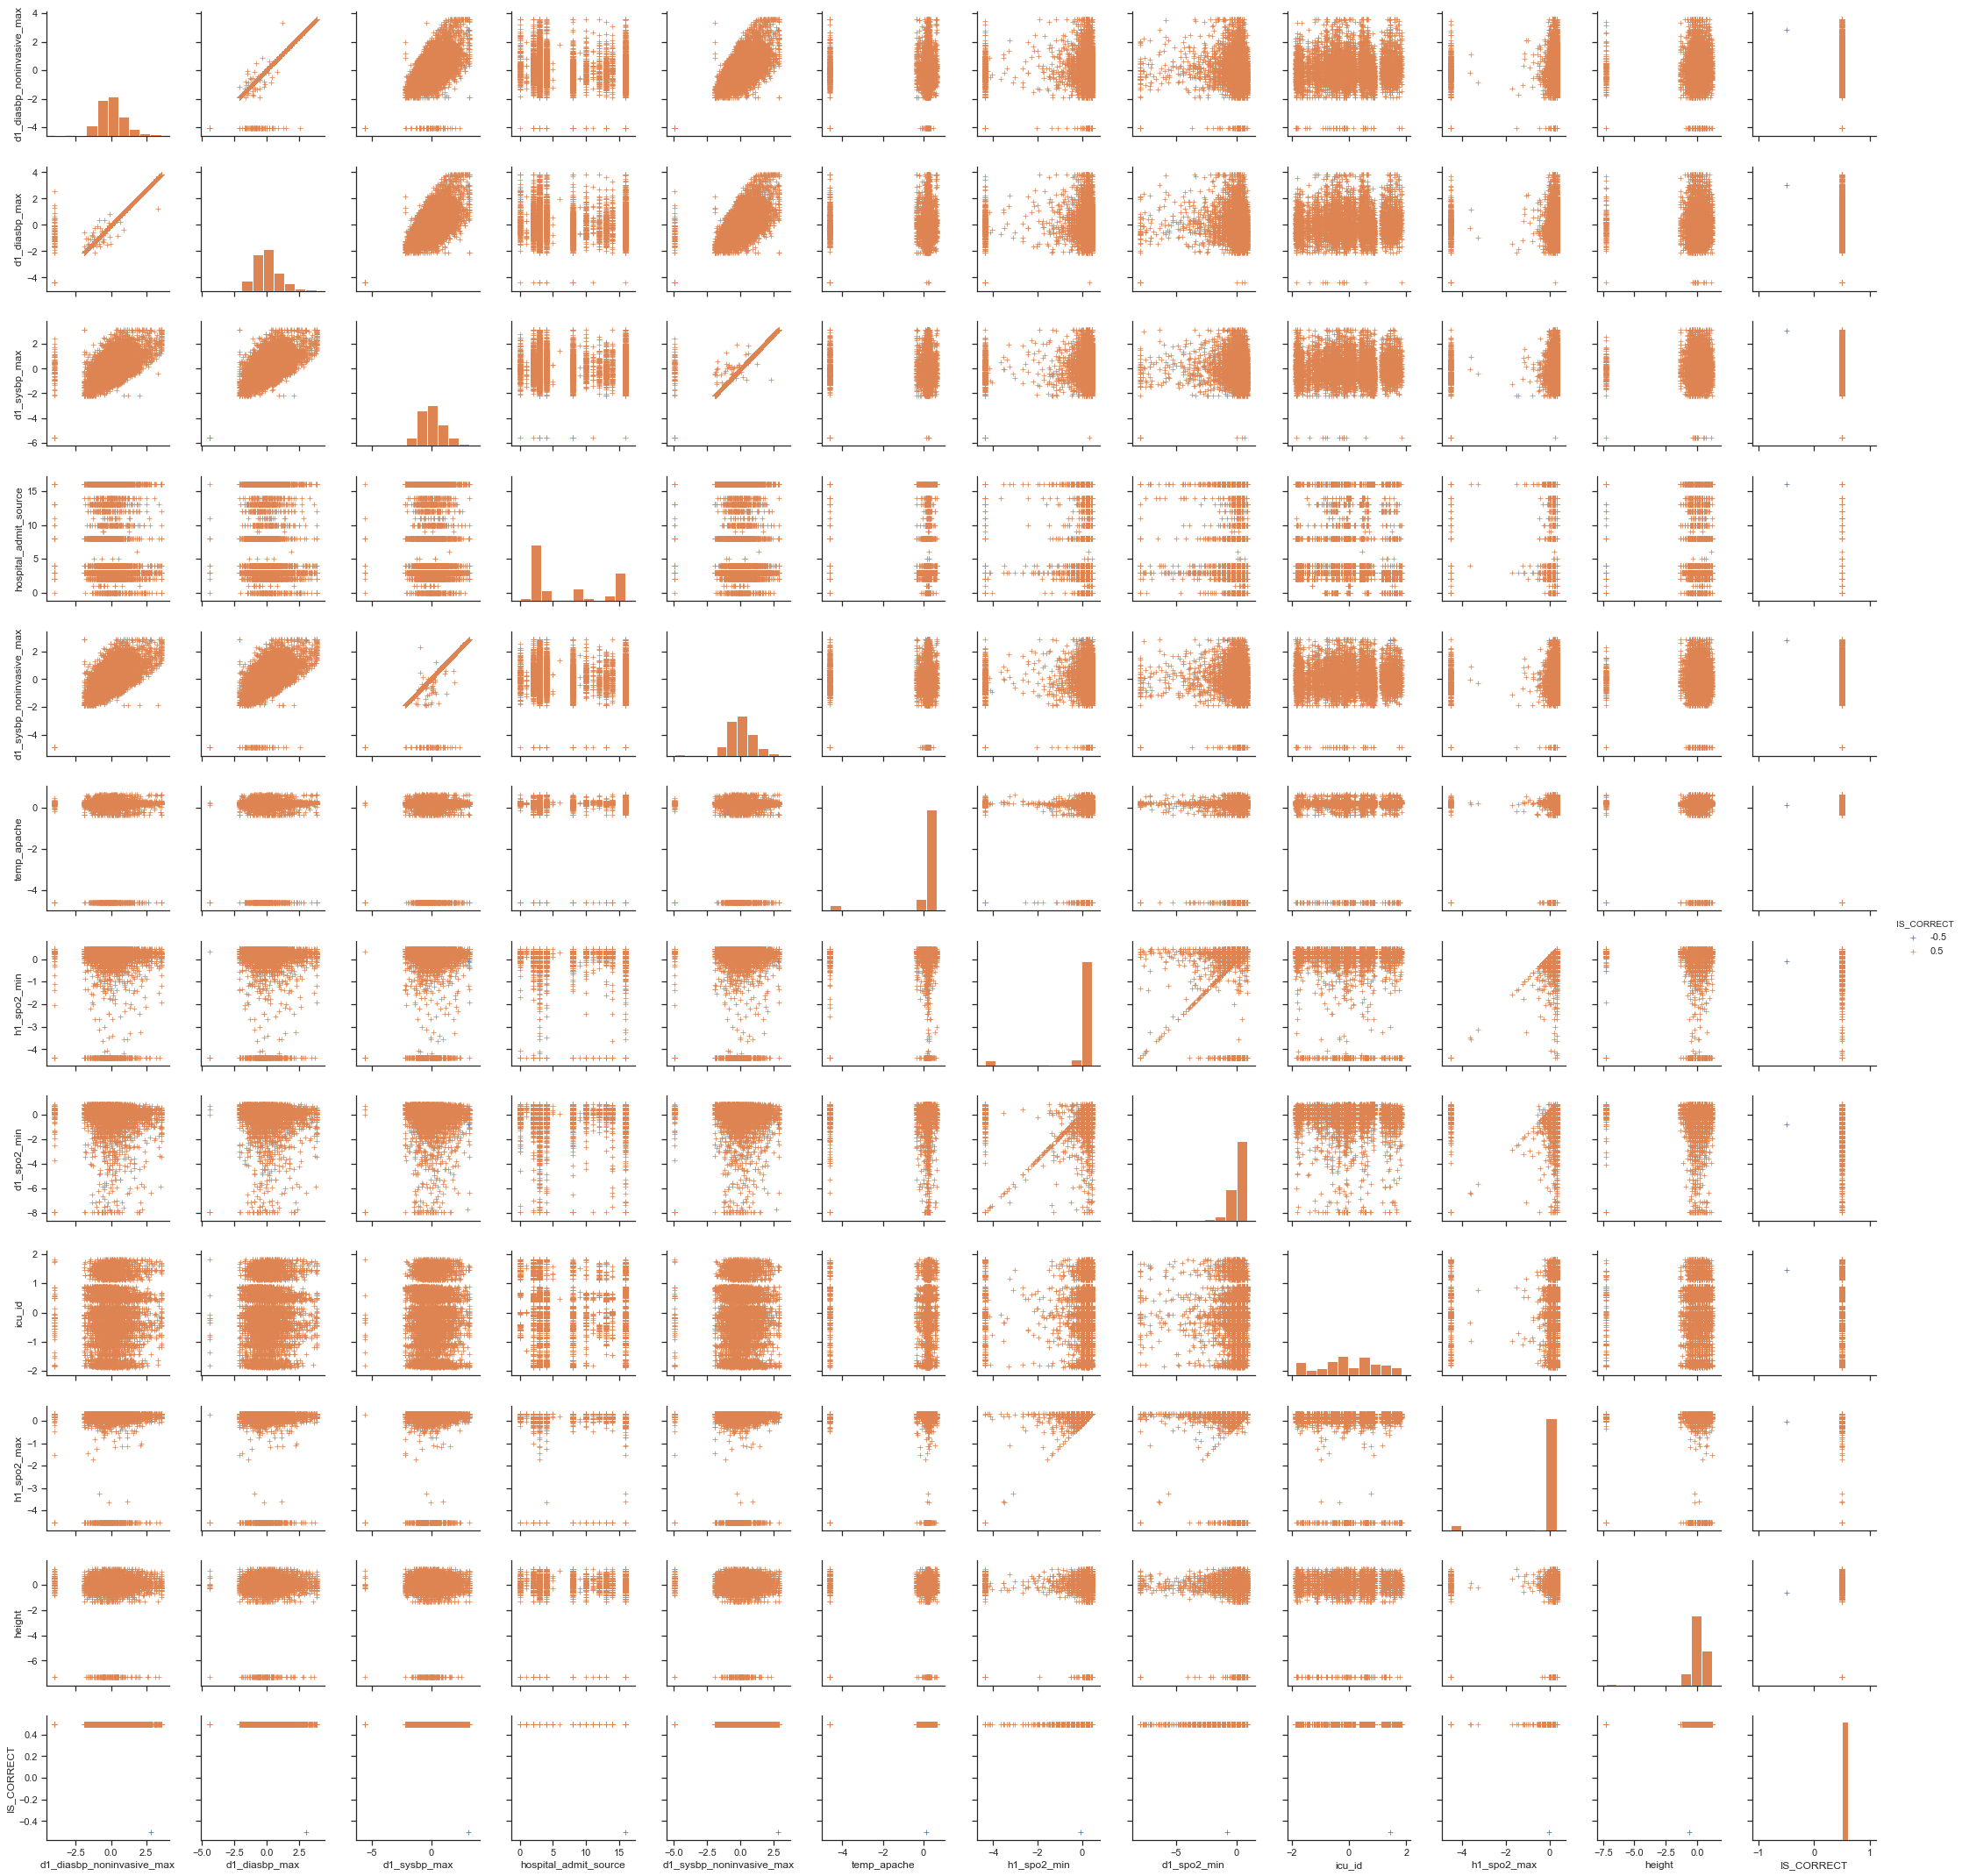

In [100]:
g = sns.pairplot(val[neg_corr + pos_corr + pathological_corr + ['IS_CORRECT']], markers="+",  hue='IS_CORRECT', diag_kind='hist')

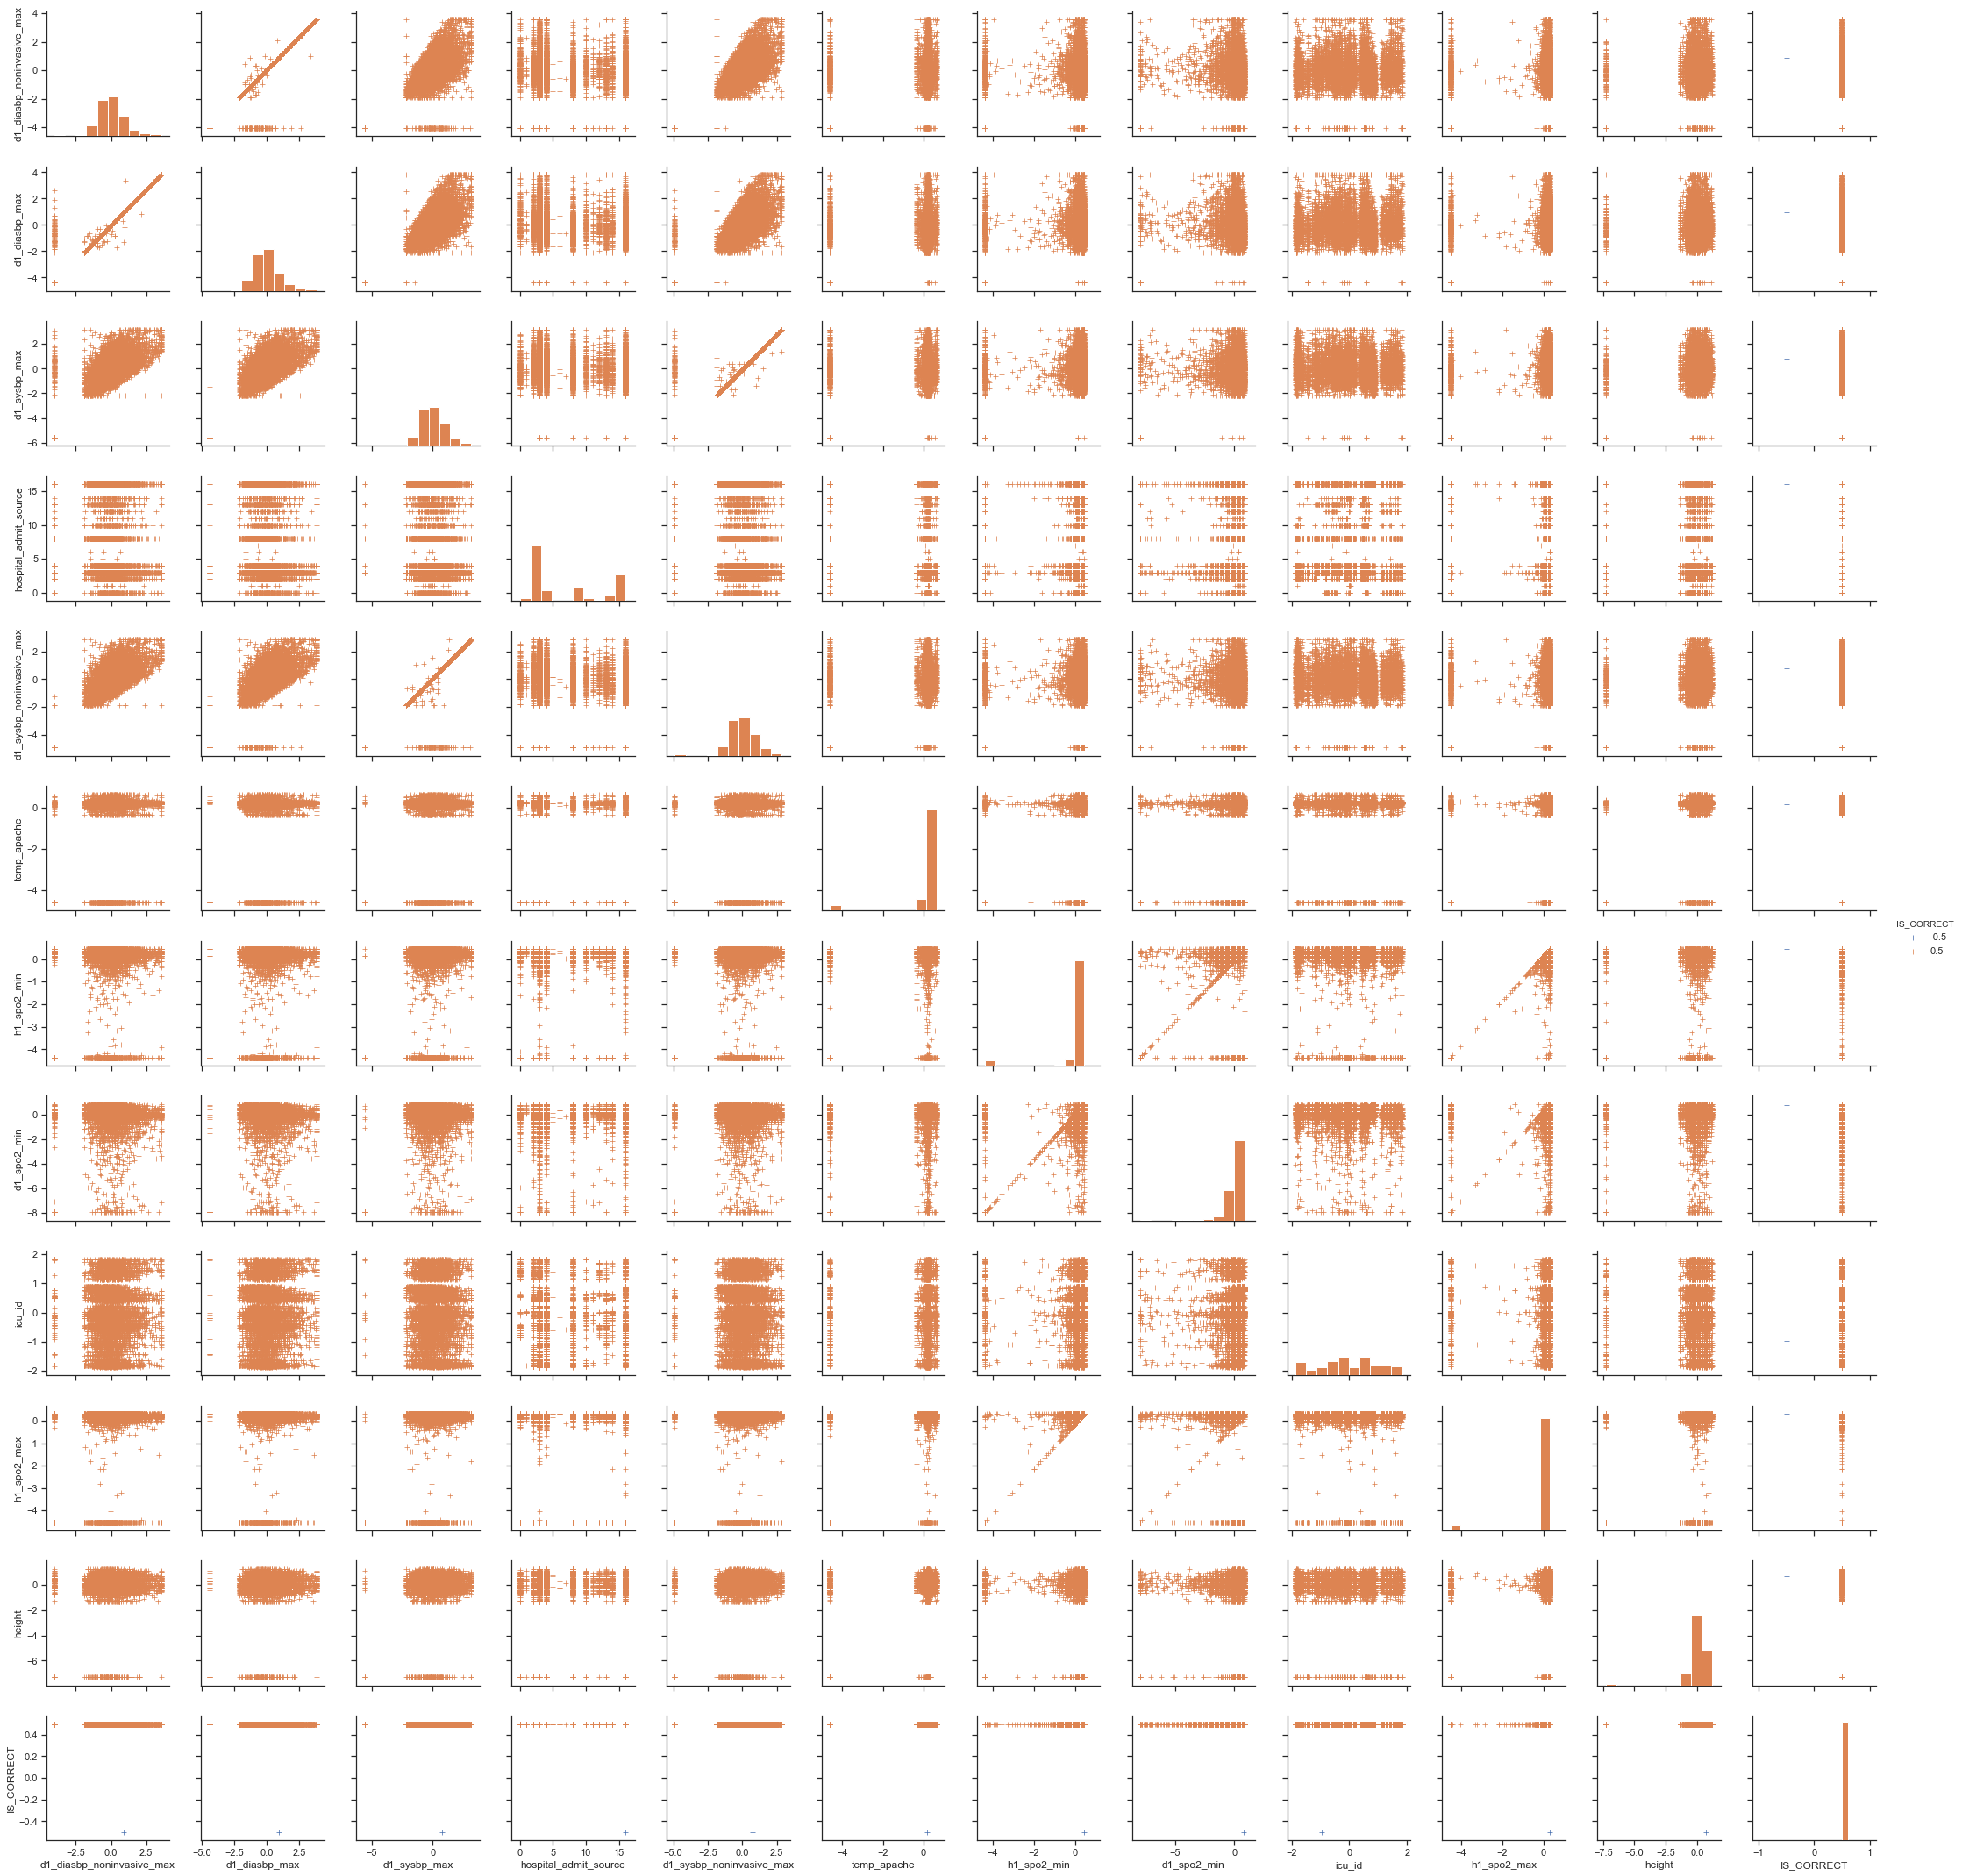

In [101]:
h = sns.pairplot(test[neg_corr + pos_corr + pathological_corr + ['IS_CORRECT']], markers="+", hue='IS_CORRECT', diag_kind='hist')